In [ ]:
# for quantify the substrate

In [2]:
%cd ~/REVIVAL2
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

/disk2/fli/REVIVAL2


In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from REVIVAL.util import get_file_name

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, DataStructs

from REVIVAL.global_param import LIB_INFO_DICT

/disk2/fli/miniconda3/envs/SSMuLA_2/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [4]:
common_cols = [
    "lib",
    "hd",
    "ev_score",
    "esm_score",
    "esmif_score_apo-score",
    "coves_score_apo_clean-output-100_processed",
    "Triad_score_score-frompdb-cleanup",
    "ligandmpnn_score",
    "flowsite_score",
    "complexscore",
    "vina_apo-score-substrate_cofactor-docked",
    "var_vol",
]
common_heme_col = common_cols + [
    "chain_iptm_BA_avg_score_seperate_chai",
    "chain_pae_min_CA_avg_score_seperate_af3",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate",
    "num_hydrogen_bond_avg_af3-score_seperate",
    # "num_interactions_avg_af3-score_seperate"
]


common_col_dict = {
    "lib": "Library",
    "hd": "Hamming distance",
    "ev_score": "EVmutation",
    "esm_score": "ESM2",
    "esmif_score_apo-score": "ESM-IF",
    "coves_score_apo_clean-output-100_processed": "CoVES",
    "Triad_score_score-frompdb-cleanup": "Triad",
    "ligandmpnn_score": "LigandMPNN",
    "flowsite_score": "FlowSite",
    "complexscore": "GALigandock",
    "vina_apo-score-substrate_cofactor-docked": "Vina",
    "var_vol": "Active site volume",
}
common_heme_col_dict = {
    **common_col_dict,
    "chain_iptm_BA_avg_score_seperate_chai": "Chai",
    "chain_pae_min_CA_avg_score_seperate_af3": "AF3",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate": "Hydrophobicity",
    "num_hydrogen_bond_avg_af3-score_seperate": "Hydrogen bonds",
    # "num_interactions_avg_af3-score_seperate": "PLIP",
}

trpb_cols = common_cols + [
    "chain_iptm_AB_avg_score_joint_chai",
    "chain_pae_min_BA_avg_score_joint_af3",
    "2:GLU-NH_2_avg_af3-struct_joint",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
    "num_hydrogen_bond_avg_af3-score_joint",
    # "num_interactions_avg_af3-score_joint"
]

trpb_col_dict = {
    **common_col_dict,
    "chain_iptm_AB_avg_score_joint_chai": "Chai",
    "chain_pae_min_BA_avg_score_joint_af3": "AF3",
    "2:GLU-NH_2_avg_af3-struct_joint": "Bond distance",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
    "num_hydrogen_bond_avg_af3-score_joint": "Hydrogen bonds",
    # "num_interactions_avg_af3-score_joint": "PLIP",
}

parlq_cols = common_heme_col + ["0:C-C_1_avg_af3-struct_seperate"]

parlq_col_dict = {
    **common_heme_col_dict,
    "0:C-C_1_avg_af3-struct_seperate": "Bond distance",
}

cb_col = common_heme_col + ["0:C-B_avg_af3-struct_seperate"]

cb_col_dict = {**common_heme_col_dict, "0:C-B_avg_af3-struct_seperate": "Bond distance"}

csi_col = common_heme_col + ["0:C-Si_avg_af3-struct_seperate"]
csi_col_dict = {
    **common_heme_col_dict,
    "0:C-Si_avg_af3-struct_seperate": "Bond distance",
}

In [5]:
col_order = [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai",
            "AF3",
            "GALigandock",
            "Vina",
            "Bond distance",
            "Hydrogen bonds",
            # "PLIP",
            "Hydrophobicity",
            "Active site volume",
        ]

In [6]:
lib_order = [
    "PfTrpB-7iodo",
    "PfTrpB-7methyl",
    "PfTrpB-7bromo",
    "PfTrpB-5iodo",
    "PfTrpB-5bromo",
    "PfTrpB-5chloro",
    "PfTrpB-4bromo",
    "PfTrpB-6chloro",
    "PfTrpB-5cyano",
    "PfTrpB-4cyano",
    "PfTrpB-56chloro",
    "Rma-CB",
    "Rma-CSi",
    "ParLQ",
    "ParLQ-b",
    "ParLQ-c",
    "ParLQ-d",
    "ParLQ-e",
    "ParLQ-f",
    "ParLQ-g",
    "ParLQ-h",
    "ParLQ-i",
]
# substrate
# 7iodo       0.605263
# 7methyl     0.605263
# 7bromo      0.605263
# 5iodo       0.600000
# 5bromo      0.600000
# 5chloro     0.600000
# 4bromo      0.550000
# 6chloro     0.536585
# 5cyano      0.489796
# 4cyano      0.489362
# 56chloro    0.333333
# Name: Atom Pair, dtype: float64


In [7]:
df_rho = pd.read_csv("/disk2/fli/REVIVAL2/zs/metrics/fit_rho.csv")
df_rho

,lib,selectivity,n_mut,hd,ev_score,esm_score,flowsite_score,flowsite_std,ligandmpnn_score,var_vol,...,0:C-Si_agg_af3-struct_joint,0:C-Si_avg_af3-struct_joint,0:C-Si_std_af3-struct_joint,0:C-Si_agg_af3-struct_seperate,0:C-Si_avg_af3-struct_seperate,0:C-Si_std_af3-struct_seperate,0:C-Si_avg_chai-struct_joint,0:C-Si_std_chai-struct_joint,0:C-Si_avg_chai-struct_seperate,0:C-Si_std_chai-struct_seperate
0,ParLQ,0.961007,0.231575,-0.231575,0.064764,-0.016563,0.149739,0.767178,0.102997,0.261154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PfTrpB-5iodo,NaN,-0.268085,0.268085,0.419296,0.479928,0.426583,0.234349,0.428536,-0.137772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PfTrpB-5bromo,NaN,-0.331510,0.331510,0.487423,0.523450,0.404282,0.289631,0.462262,-0.025118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PfTrpB-5cyano,NaN,-0.301809,0.301809,0.396476,0.425708,0.382270,0.268198,0.440015,0.042512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ParLQ-c,0.933491,0.322762,-0.160432,0.008082,-0.260408,-0.125243,0.351489,-0.272798,0.114471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ParLQ-g,0.709738,0.225021,-0.064206,0.033065,-0.095302,0.129352,0.138254,0.049180,0.254765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,PfTrpB-56chloro,NaN,-0.318860,0.318860,0.388337,0.461043,0.316607,0.348094,0.445602,0.028684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ParLQ-i,0.761773,0.406881,-0.267521,-0.155426,-0.326358,-0.052970,0.223252,-0.226835,0.123287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ParLQ-d,0.932596,0.283932,-0.131004,-0.019998,-0.212725,0.159946,0.293343,0.013028,0.096199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,PfTrpB-6chloro,NaN,-0.417893,0.417893,0.569694,0.612678,0.457337,0.241263,0.576349,0.055604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
cb_df = df_rho[df_rho["lib"] == "Rma-CB"][cb_col].rename(columns=cb_col_dict).reset_index(drop=True).copy()
csi_df = df_rho[df_rho["lib"] == "Rma-CSi"][csi_col].rename(columns=csi_col_dict).reset_index(drop=True).copy()
parlq_df = df_rho[df_rho["lib"].isin(lib_order[-9:])][parlq_cols].rename(columns=parlq_col_dict).reset_index(drop=True).copy()
parlq_df.loc[parlq_df["Library"]=="ParLQ", "Library"] = "ParLQ-a"
new2nature_df = pd.concat([cb_df, csi_df, parlq_df], axis=0).reset_index(drop=True).sort_values(by="Library")
new2nature_df

,Library,Hamming distance,EVmutation,ESM2,ESM-IF,CoVES,Triad,LigandMPNN,FlowSite,GALigandock,Vina,Active site volume,Chai,AF3,Hydrophobicity,Hydrogen bonds,Bond distance
2,ParLQ-a,-0.231575,0.064764,-0.016563,0.278441,0.035015,0.278514,0.102997,0.149739,-0.051786,-0.003070,0.261154,-0.127618,0.356036,0.383057,-0.182839,0.139871
8,ParLQ-b,-0.214107,-0.019517,-0.350559,-0.163650,-0.442324,-0.229385,-0.364423,-0.088342,NaN,0.054419,0.169803,0.235515,0.279577,-0.098895,-0.020658,-0.076392
3,ParLQ-c,-0.160432,0.008082,-0.260408,-0.069025,-0.332778,-0.201736,-0.272798,-0.125243,NaN,0.149959,0.114471,0.233500,0.331139,-0.073357,0.195079,-0.285940
6,ParLQ-d,-0.131004,-0.019998,-0.212725,-0.082542,-0.127608,-0.205686,0.013028,0.159946,NaN,0.046004,0.096199,0.173882,0.448956,-0.068977,0.179523,-0.172705
9,ParLQ-e,-0.094295,-0.086666,-0.126422,0.057443,-0.042569,-0.012988,0.080714,0.206172,NaN,0.010041,0.051132,0.141194,0.415910,-0.047357,0.075807,-0.100212
7,ParLQ-f,-0.099254,0.095200,-0.133461,0.041760,-0.162178,-0.088788,-0.119939,0.054642,NaN,0.043328,0.191889,0.070851,0.342681,-0.038439,0.118567,-0.012322
4,ParLQ-g,-0.064206,0.033065,-0.095302,0.037475,-0.019119,0.019541,0.049180,0.129352,NaN,-0.067146,0.254765,0.140176,0.350337,-0.025912,0.046244,-0.106046
10,ParLQ-h,-0.231071,-0.041467,-0.302914,-0.110238,-0.251123,-0.067718,-0.273802,-0.164055,NaN,0.142854,0.249194,0.225645,0.357259,-0.053305,-0.050766,0.002998
5,ParLQ-i,-0.267521,-0.155426,-0.326358,-0.121088,-0.157385,-0.226039,-0.226835,-0.052970,NaN,0.009919,0.123287,0.336836,0.387596,-0.107756,0.060247,-0.007020
0,Rma-CB,0.061590,0.241046,0.214661,0.130128,0.038847,0.108142,0.260575,0.118630,0.094297,0.071539,-0.214222,0.173947,0.362757,0.099902,0.174850,0.037481


In [27]:
arbitratey_energy = {
    "ParLQ-a": 11,
    "ParLQ-b": 14.5,
    "ParLQ-c": 12.5,
    "ParLQ-d": 13.5,
    "ParLQ-e": 16,
    "ParLQ-f": 17,
    "ParLQ-g": 18,
    "ParLQ-h": 20,
    "ParLQ-i": 21,
    "Rma-CSi": 19,
    "Rma-CB": 13,
}
arbitratey_energy = {k: v for k, v in sorted(arbitratey_energy.items(), key=lambda item: item[1])}

In [10]:
# Convert the 'substrate' column to a Categorical type with the custom order
# trpb_df['substrate'] = pd.Categorical(trpb_df['substrate'], categories=atom_pair_vals.keys(), ordered=True)

# # Sort the DataFrame based on the 'substrate' column
# trpb_df = trpb_df.sort_values('substrate')



#  Melt the dataframe to long format for seaborn boxplot and stripplot
new2nature_melted = pd.melt(
    new2nature_df[col_order],
    id_vars="Library",
    var_name="ZS predictor",
    value_name="Spearman's ρ with fitness",
)
# trpbdf_melted["ZS predictor"] = pd.Categorical(trpbdf_melted['ZS predictor'], categories=col_order, ordered=True)
# trpbdf_melted = trpbdf_melted.sort_values(['substrate','ZS predictor'])
new2nature_melted

,Library,ZS predictor,Spearman's ρ with fitness
0,ParLQ-a,Hamming distance,-0.231575
1,ParLQ-b,Hamming distance,-0.214107
2,ParLQ-c,Hamming distance,-0.160432
3,ParLQ-d,Hamming distance,-0.131004
4,ParLQ-e,Hamming distance,-0.094295
...,...,...,...
171,ParLQ-g,Active site volume,0.254765
172,ParLQ-h,Active site volume,0.249194
173,ParLQ-i,Active site volume,0.123287
174,Rma-CB,Active site volume,-0.214222


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from REVIVAL.vis_param import FZL_PALETTES

%matplotlib inline

/tmp/ipykernel_2047605/3730899316.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Greens_r")
/tmp/ipykernel_2047605/3730899316.py:25: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


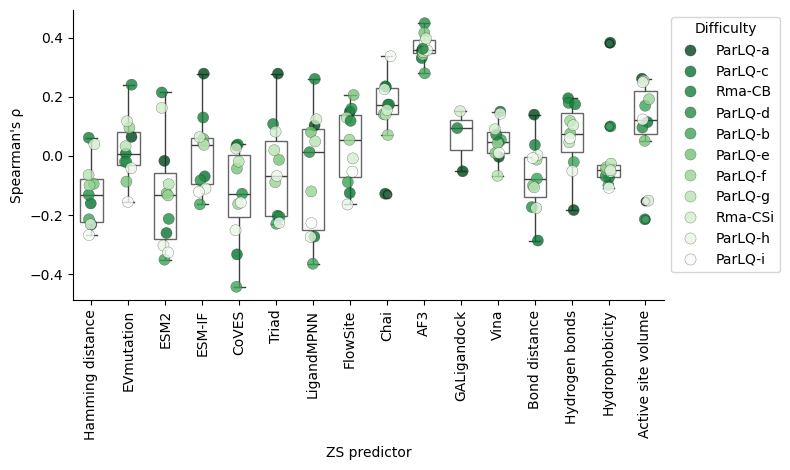

In [33]:
heatmap_values = arbitratey_energy
new2nature_melted["energy"] = new2nature_melted["Library"].map(heatmap_values)

# Normalize heatmap values for colormap
norm = Normalize(vmin=min(heatmap_values.values()), vmax=max(heatmap_values.values()))
cmap = get_cmap("Greens_r")

# Map substrates to colors
substrate_colors = {
    substrate: cmap(norm(value)) for substrate, value in heatmap_values.items()
}

# Create the boxplot and stripplot
plt.figure(figsize=(8, 4.8))
ax = sns.boxplot(
    x="ZS predictor",
    y="Spearman's ρ with fitness",
    data=new2nature_melted,
    boxprops={
        "facecolor": "None",
        "edgecolor": FZL_PALETTES["gray"],
    },
    width=0.6
)
sns.stripplot(
    x="ZS predictor",
    y="Spearman's ρ with fitness",
    hue="Library",
    data=new2nature_melted,
    palette=substrate_colors,  # glasbey_category10[:11],
    jitter=True,
    # dodge=True,
    size=8,
    marker="o",
    edgecolor="gray",
    linewidth=0.2,
    alpha=0.8,
    ax=ax,
    hue_order=heatmap_values.keys(),
)

# Hide the top and right spine
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# rotate x-axis labels
plt.xticks(rotation=90)

# Adjust legend
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", title="Difficulty")

# Adjust the legend order explicitly (use the custom order if necessary)
# handles, labels = ax.get_legend_handles_labels()
# sorted_handles_labels = sorted(zip(labels, handles), key=lambda x: list(heatmap_values.keys()).index(x[0]))
# sorted_labels, sorted_handles = zip(*sorted_handles_labels)
# ax.legend(sorted_handles, sorted_labels, title="Substrate")
# rename the y-axis
plt.ylabel("Spearman's ρ")
plt.savefig("figs/new2nature.svg", format="svg", dpi=300, bbox_inches="tight")
# Show the plot
plt.tight_layout()
plt.show()


In [35]:
# merge with energy
new2nature_df = new2nature_df.merge(
    pd.DataFrame(arbitratey_energy.items(), columns=["Library", "energy"]),
    on="Library",
    how="left",
)
new2nature_df

,Library,Hamming distance,EVmutation,ESM2,ESM-IF,CoVES,Triad,LigandMPNN,FlowSite,GALigandock,Vina,Active site volume,Chai,AF3,Hydrophobicity,Hydrogen bonds,Bond distance,energy
0,ParLQ-a,-0.231575,0.064764,-0.016563,0.278441,0.035015,0.278514,0.102997,0.149739,-0.051786,-0.003070,0.261154,-0.127618,0.356036,0.383057,-0.182839,0.139871,11.0
1,ParLQ-b,-0.214107,-0.019517,-0.350559,-0.163650,-0.442324,-0.229385,-0.364423,-0.088342,NaN,0.054419,0.169803,0.235515,0.279577,-0.098895,-0.020658,-0.076392,14.5
2,ParLQ-c,-0.160432,0.008082,-0.260408,-0.069025,-0.332778,-0.201736,-0.272798,-0.125243,NaN,0.149959,0.114471,0.233500,0.331139,-0.073357,0.195079,-0.285940,12.5
3,ParLQ-d,-0.131004,-0.019998,-0.212725,-0.082542,-0.127608,-0.205686,0.013028,0.159946,NaN,0.046004,0.096199,0.173882,0.448956,-0.068977,0.179523,-0.172705,13.5
4,ParLQ-e,-0.094295,-0.086666,-0.126422,0.057443,-0.042569,-0.012988,0.080714,0.206172,NaN,0.010041,0.051132,0.141194,0.415910,-0.047357,0.075807,-0.100212,16.0
5,ParLQ-f,-0.099254,0.095200,-0.133461,0.041760,-0.162178,-0.088788,-0.119939,0.054642,NaN,0.043328,0.191889,0.070851,0.342681,-0.038439,0.118567,-0.012322,17.0
6,ParLQ-g,-0.064206,0.033065,-0.095302,0.037475,-0.019119,0.019541,0.049180,0.129352,NaN,-0.067146,0.254765,0.140176,0.350337,-0.025912,0.046244,-0.106046,18.0
7,ParLQ-h,-0.231071,-0.041467,-0.302914,-0.110238,-0.251123,-0.067718,-0.273802,-0.164055,NaN,0.142854,0.249194,0.225645,0.357259,-0.053305,-0.050766,0.002998,20.0
8,ParLQ-i,-0.267521,-0.155426,-0.326358,-0.121088,-0.157385,-0.226039,-0.226835,-0.052970,NaN,0.009919,0.123287,0.336836,0.387596,-0.107756,0.060247,-0.007020,21.0
9,Rma-CB,0.061590,0.241046,0.214661,0.130128,0.038847,0.108142,0.260575,0.118630,0.094297,0.071539,-0.214222,0.173947,0.362757,0.099902,0.174850,0.037481,13.0


In [36]:
corr_df_list = []
num_cols = new2nature_df.columns[1:-1]
for num_col in num_cols:
    rho, pval = spearmanr(new2nature_df[num_col], new2nature_df["energy"])
    corr_df_list.append({
        "num_col": num_col,
        "rho": rho,
        "pval": pval,
    })

corr_df = pd.DataFrame(corr_df_list)
corr_df

,num_col,rho,pval
0,Hamming distance,-0.063636,0.852539
1,EVmutation,-0.363636,0.271638
2,ESM2,-0.281818,0.401145
3,ESM-IF,-0.418182,0.200570
4,CoVES,-0.181818,0.592615
5,Triad,-0.236364,0.484091
6,LigandMPNN,-0.236364,0.484091
7,FlowSite,-0.327273,0.325895
8,GALigandock,NaN,NaN
9,Vina,-0.072727,0.831716
